Experimented originally with creating image match
https://github.com/MarcoForte/closed-form-matting/blob/master/closed_form_matting.py
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.134.8491&rep=rep1&type=pdf

In [1]:
import sys
sys.path.append('/Users/rsingh/Oyla/Work/our_python_dev/')
sys.path.append('/Users/rsingh/Packages/closed-form-matting//')

In [2]:
import closed_form_matting
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.io

In [3]:
from oyla.mvc.utils import *
from solve_foreground_background import solve_foreground_background

In [4]:
from skimage.util import view_as_windows

In [5]:
from solve_foreground_background import solve_foreground_background

In [6]:
dir_path='/Users/rsingh/Oyla Dropbox/Oyla/02 Technical/10 Data/Oct 16 - RG visit Set 3/27_SpotB_data_October_16_20_37_05///'

In [7]:
input_data_folder_name =  dir_path
csv_file = input_data_folder_name+'/parameters.csv'
parameters = read_csv_parameters(csv_file)

dict_keys(['Section', 'Type', 'Key', 'Argument Format', 'Value', 'Command Group', 'Description'])


In [8]:
ambiguity_distance, range_max, range_min, saturation_flag, adc_flag, mod_freq, ampl_min,reflectivity_thresh = some_common_utility(parameters,0)

In [58]:
filter_params = {}
filter_parameters = {}
filter_parameters['filter_cmd'] = {}
filter_parameters = read_csv_parameters("/Users/rsingh/Oyla/Work/our_python_dev/oyla/mvc/filter_params.csv")
for k in filter_parameters['filter_cmd'].keys():
        #print(parameters['filter_cmd'][k][self.epoch_number])
        try:
                filter_params[k] = int(filter_parameters['filter_cmd'][k][0])
                #parameters['filter_cmd'][k][0] = filter_parameters['filter_cmd'][k][0]
        except ValueError:
                pass

dict_keys(['Section', 'Type', 'Key', 'Argument Format', 'Value', 'Command Group', 'Description'])


In [59]:
#filter_params['median_filter'] = 1

#filter_params['edge_detection'] = 1
#filter_params['edge_detection_thresholds'] = 10

In [84]:
index = np.random.randint(0,500)

#index = 287
print(index)
rgb = scipy.io.loadmat(dir_path+'/data_c_'+str(index)+'.mat')

rgb = rgb['data'][0][4]

rgb = rgb_depth_view_matching(rgb)

dist = np.fromfile(dir_path+'/imageDistance_c_'+str(index)+'.bin',np.uint16())
ampl = np.fromfile(dir_path+'/imageDistance_c_'+str(index)+'_ampl.bin',np.uint16())

#dist = dist.reshape(120,320)
#ampl = ampl.reshape(120,320)

raw_phase = dist.reshape(120,320)
raw_ampl = ampl.reshape(120,320)
filtered_phase, thresholded_ampl, indices = threshold_filter(raw_phase = raw_phase, raw_ampl = raw_ampl, reflectivity_thresh= reflectivity_thresh,
                                                                             range_max = range_max, range_min = range_min, ampl_min = ampl_min,
                                                                             filter_params = filter_params, ambiguity_distance = ambiguity_distance)

368


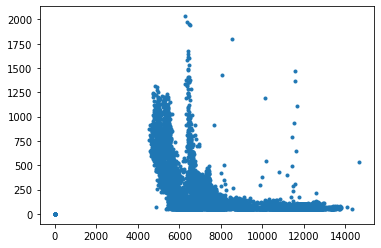

In [85]:
plt.plot(filtered_phase[raw_ampl<65000],thresholded_ampl[raw_ampl<65000],'.')

In [86]:
trimap = filtered_phase.copy()
#trimap = trimap.astype('float32')
trimap[trimap>-1] = 0.5
trimap[(filtered_phase>=5000)&(filtered_phase<11000)] = 1
#trimap[filtered_phase<=500] = 0.5
trimap[thresholded_ampl<100] = 0
#trimap[ampl<=100] = 0.0

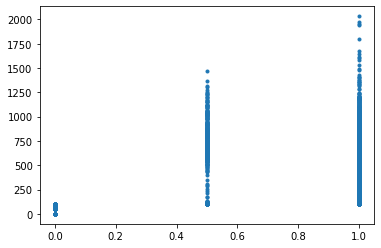

In [87]:
plt.plot(trimap[raw_ampl<65000],thresholded_ampl[raw_ampl<65000],'.')

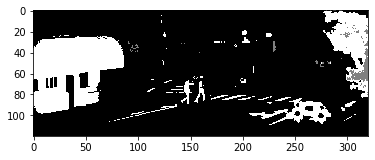

In [88]:
plt.imshow(trimap,cmap='gray')

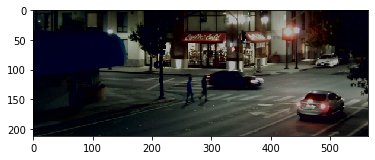

In [89]:
plt.imshow(rgb)
_rgb = cv2.resize(rgb,None,fx=120/212,fy=120/212)
_rgb = _rgb.astype('float32')/255.0

In [90]:
alpha = closed_form_matting.closed_form_matting_with_trimap(_rgb, trimap)

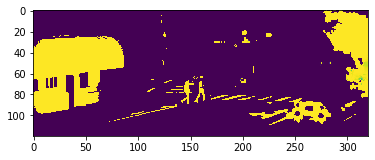

In [91]:
plt.imshow(alpha)

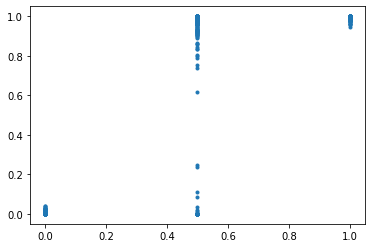

In [92]:
plt.plot(trimap.reshape(-1),alpha.reshape(-1),'.')

In [93]:
foreground, background = solve_foreground_background(_rgb, alpha)


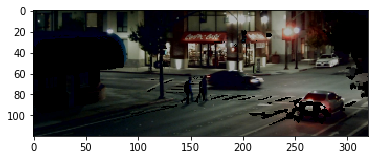

In [94]:
plt.imshow(background)

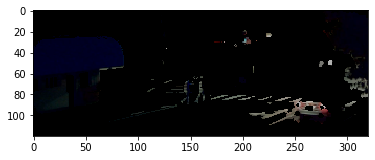

In [95]:
#output = np.concatenate((foreground, alpha[:, :, np.newaxis]), axis=2)
plt.imshow(foreground)

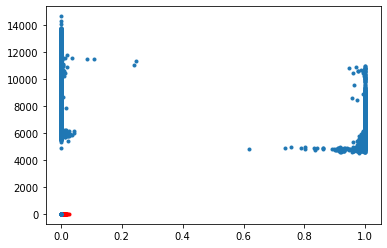

In [96]:
plt.plot(alpha[raw_ampl>65000],filtered_phase[raw_ampl>65000],'r.')
plt.plot(alpha[raw_ampl<65000],filtered_phase[raw_ampl<65000],'.')

In [97]:
fhsv = cv2.cvtColor(foreground.astype('float32'),cv2.COLOR_RGB2HSV)

In [98]:
bhsv = cv2.cvtColor(background.astype('float32'),cv2.COLOR_RGB2HSV)

In [99]:
f = thresholded_ampl/np.max(thresholded_ampl)#filtered_phase/np.max(filtered_phase)

In [109]:
efhsv = fhsv.copy()
efhsv[:,:,2]= efhsv[:,:,2]+np.mean(fhsv[:,:,2])
efhsv[:,:,2] = efhsv[:,:,2]/np.max(efhsv[:,:,2])

In [110]:
ebhsv = bhsv.copy()
ebhsv[:,:,2]= ebhsv[:,:,2]-np.mean(bhsv[:,:,2])
ebhsv[:,:,2] = ebhsv[:,:,2]/np.max(ebhsv[:,:,2])

In [111]:
eforeground = cv2.cvtColor(efhsv,cv2.COLOR_HSV2RGB)
ebackground = cv2.cvtColor(efhsv,cv2.COLOR_HSV2RGB)

In [112]:
I = eforeground
for i in range(3):
    I[:,:,i] = alpha*eforeground[:,:,i]+(1-alpha)*ebackground[:,:,i]

I = I-np.min(I)
I = I/np.max(I)

(-0.5, 564.5, 211.5, -0.5)

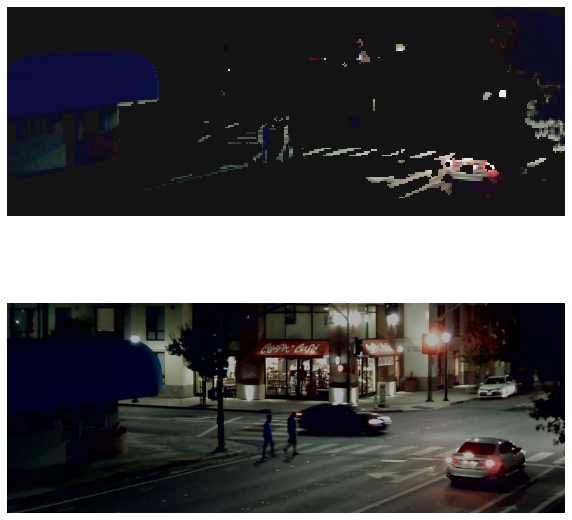

In [113]:
f, axs = plt.subplots(2,1,figsize=(10,10))

axs[0].imshow(I)
axs[0].axis('off')
axs[1].imshow(rgb)
axs[1].axis('off')

In [44]:
alpha[raw_ampl>65000]

array([0., 0., 0., ..., 0., 0., 0.])

In [51]:
beta = alpha.copy()
#beta[dist==0] = beta[dist==0]/2
beta[raw_ampl>=1000] = 0
beta[raw_ampl<1000]  = 0

In [47]:
J = 0*foreground
for i in range(3):
    J[:,:,i] = beta*foreground[:,:,i]+(1-beta)*background[:,:,i]

In [48]:
J = J-np.min(J)
J = J/np.max(J)

In [50]:
np.mean(np.abs(I-J))

0.008222093434042774

In [87]:
np.count_nonzero(dist==0)

24974

In [92]:
plt.imsave('/Users/rsingh/Downloads/testC.png',(J*255).astype('uint8'))

In [101]:
plt.imsave('/Users/rsingh/Downloads/testO.png',(I*255).astype('uint8'))

In [95]:
# This is for finding static background
bkg = []
for index in range(40):
    dist = np.fromfile(dir_path+'/imageDistance_c_'+str(index)+'.bin',np.uint16())
    dist = dist.reshape(120,320)
    bkg.append(dist)

bkg = np.asarray(bkg)

bkgD = np.median(bkg,axis=0)

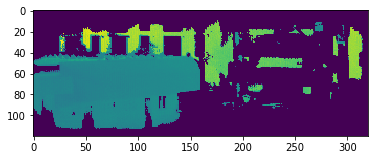

In [96]:
plt.imshow(bkgD)

In [99]:
bkg = []
for index in range(4):
    rgb = scipy.io.loadmat(dir_path+'/data_c_'+str(index)+'.mat')

    rgb = rgb['data'][0][4]

    rgb = rgb_depth_view_matching(rgb)
    bkg.append(rgb)
bkg = np.asarray(bkg)

bkgC = np.median(bkg,axis=0)
bkgC = bkgC/255.0

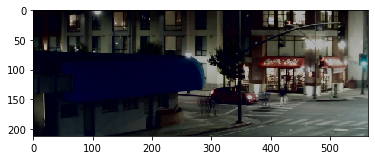

In [102]:
plt.imshow(bkgC)

In [37]:
np.min(bkgC)

0.0

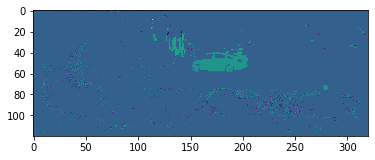

In [30]:
plt.imshow(dist-bkg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


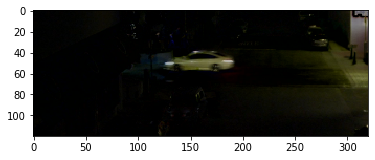

In [42]:
plt.imshow(_rgb-cv2.resize(bkgC,None,fx=120/212,fy=120/212))

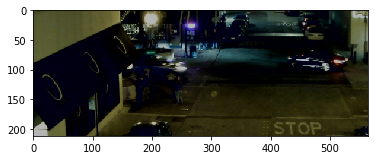

In [97]:
plt.imshow(rgb)

In [196]:
hsv = cv2.cvtColor((_rgb*255).astype('uint8'),cv2.COLOR_RGB2HSV)

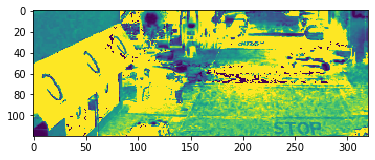

In [197]:
plt.imshow(hsv[:,:,1])

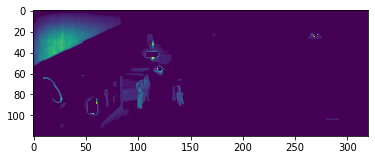

In [198]:
plt.imshow(thresholded_ampl)

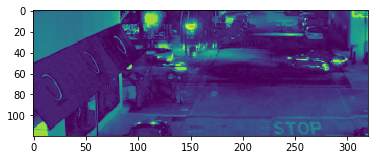

In [199]:
plt.imshow(hsv[:,:,2])

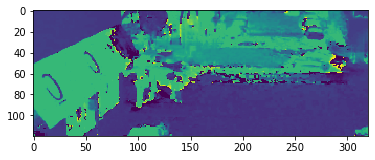

In [200]:
plt.imshow(hsv[:,:,0])

In [201]:
_ta = thresholded_ampl.astype('float32')/np.max(thresholded_ampl)

In [202]:
_ta = (_ta*255).astype('uint8')

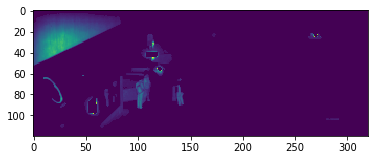

In [203]:
plt.imshow(_ta)

In [204]:
hsv[:,:,1] = _ta

In [205]:
np.min(hsv)

0

In [206]:
hsv.dtype

dtype('uint8')

In [207]:
np.max(_rgb)

0.8235294

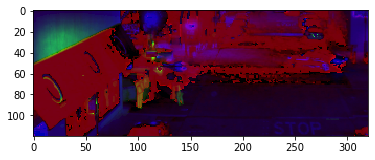

In [208]:
plt.imshow(hsv)

In [209]:
__rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

(-0.5, 319.5, 119.5, -0.5)

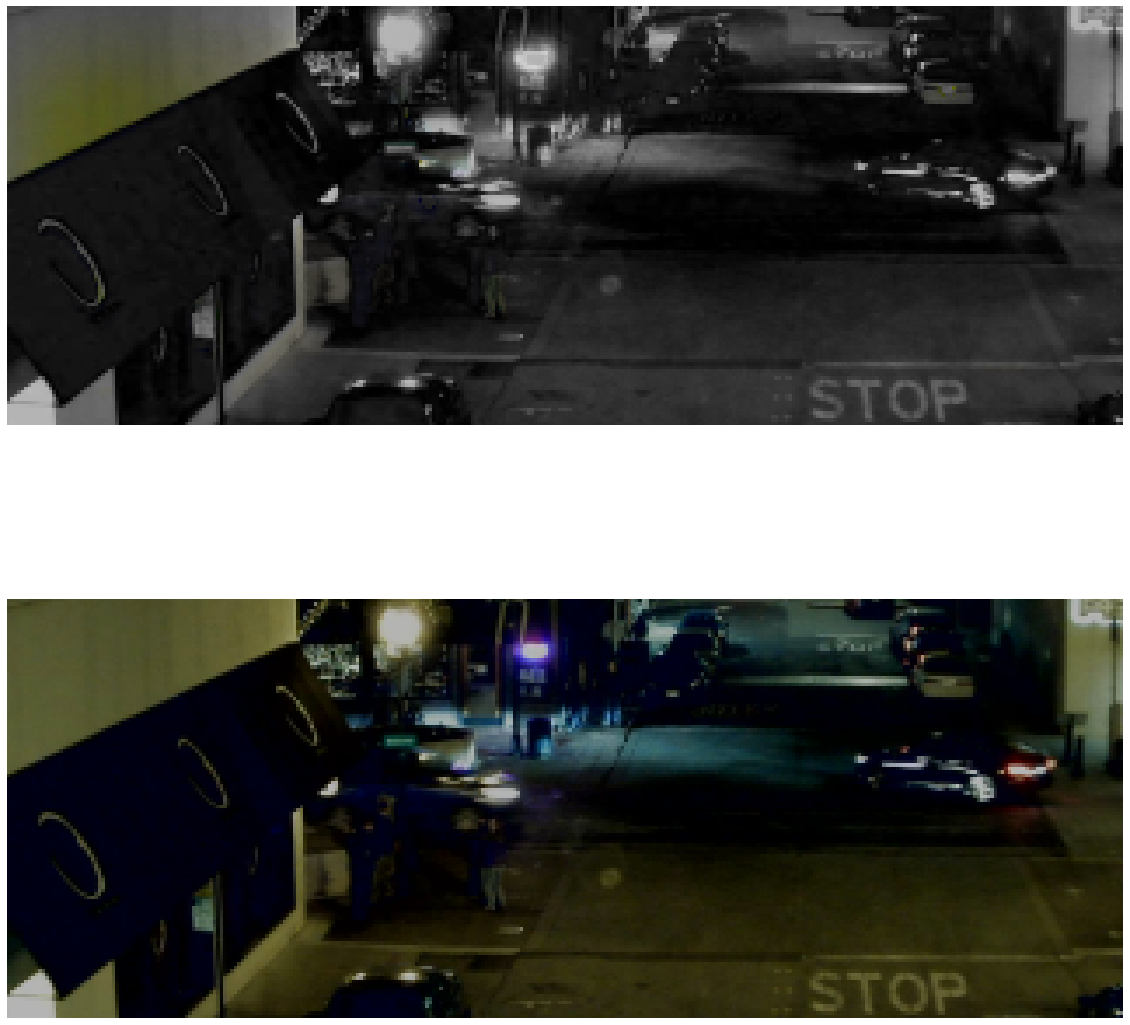

In [210]:
f, axs = plt.subplots(2,1,figsize=(20,20))

axs[0].imshow(__rgb)
axs[0].axis('off')
axs[1].imshow(_rgb)
axs[1].axis('off')

In [243]:
ycbcr = cv2.cvtColor((_rgb*255).astype('uint8'),cv2.COLOR_RGB2YCrCb)

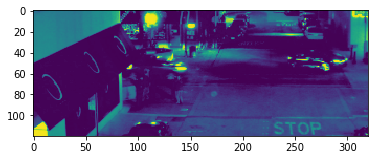

In [237]:
plt.imshow(ycbcr[:,:,0])

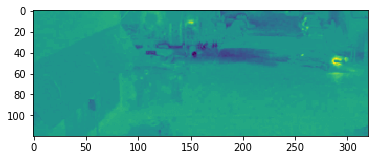

In [238]:
plt.imshow(ycbcr[:,:,1])

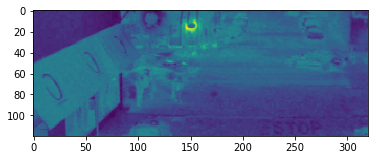

In [239]:
plt.imshow(ycbcr[:,:,2])

In [244]:
ycbcr[:,:,0] = _ta

In [245]:
__rgb = cv2.cvtColor(ycbcr,cv2.COLOR_YCrCb2RGB)

(-0.5, 319.5, 119.5, -0.5)

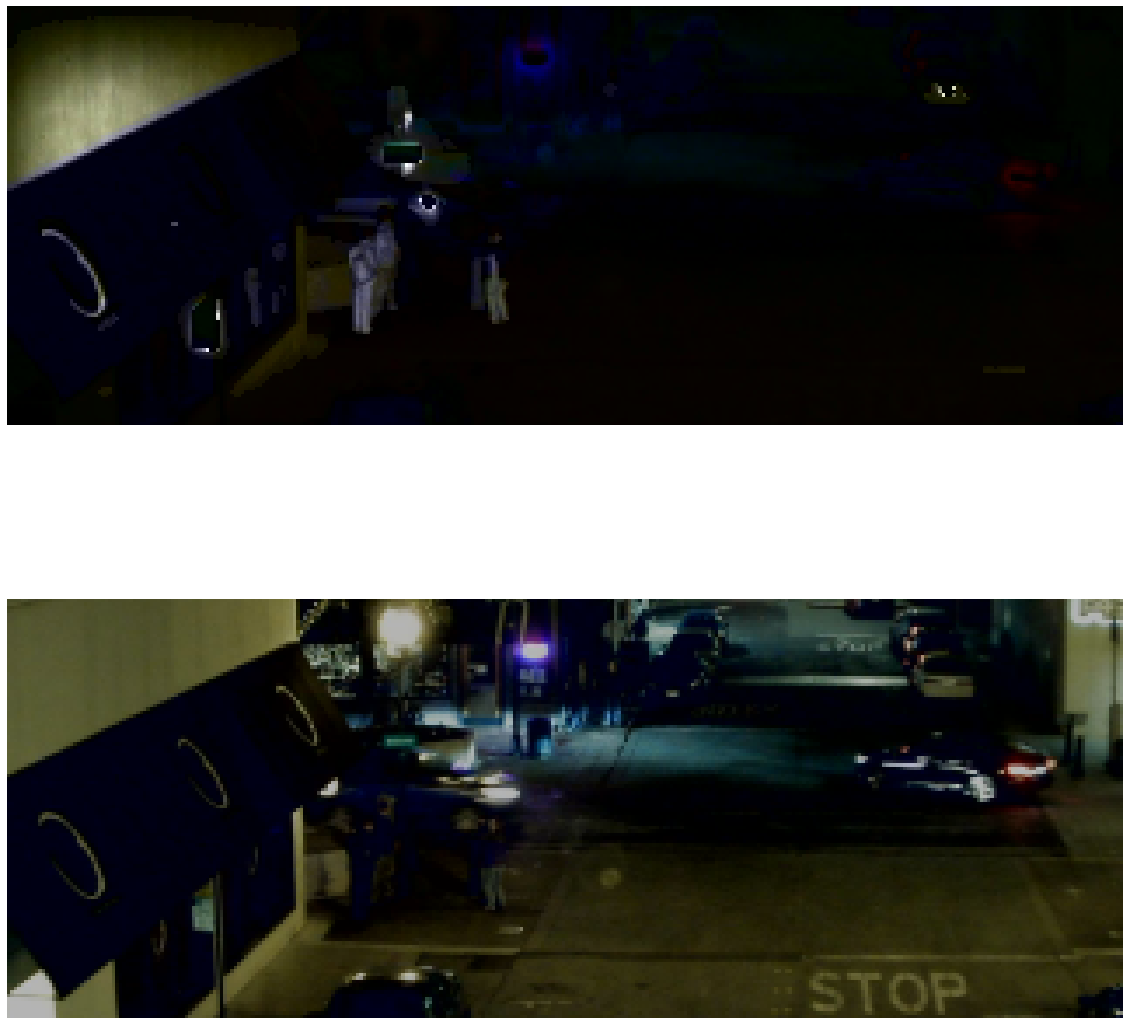

In [246]:
f, axs = plt.subplots(2,1,figsize=(20,20))

axs[0].imshow(__rgb)
axs[0].axis('off')
axs[1].imshow(_rgb)
axs[1].axis('off')

In [6]:
cd ~/Packages/closed-form-matting/

/Users/rsingh/Packages/closed-form-matting


In [7]:
trimap = plt.imread('testdata/trimap.png')

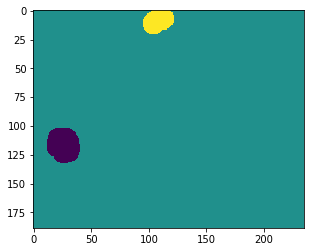

In [8]:
plt.imshow(trimap)

In [9]:
org = plt.imread('testdata/source.png')

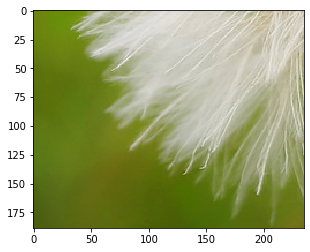

In [10]:
plt.imshow(org)

In [11]:
alpha = closed_form_matting.closed_form_matting_with_trimap(org,trimap)

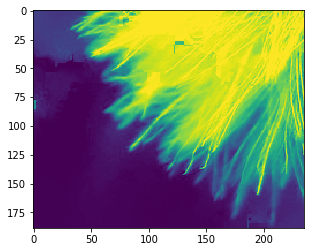

In [12]:
plt.imshow(alpha)

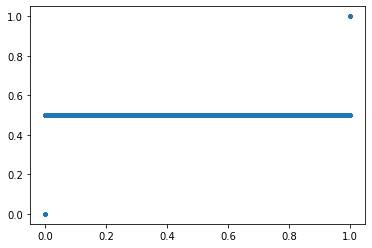

In [13]:
plt.plot(alpha.reshape(-1),trimap.reshape(-1),'.')

In [14]:
np.unique(trimap)

array([0.       , 0.5019608, 1.       ], dtype=float32)

In [15]:
np.unique(alpha)

array([0.00000000e+00, 6.07979288e-13, 4.79301927e-12, ...,
       9.99999974e-01, 1.00000000e+00, 1.00000000e+00])

In [16]:
np.unique(alpha).shape

(39825,)

In [17]:
foreground, background = solve_foreground_background(org,alpha)


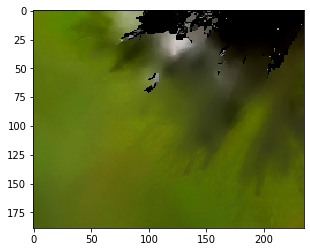

In [18]:
plt.imshow(background)

In [19]:
beta = 1

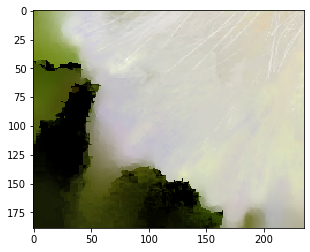

In [21]:
plt.imshow(J)

In [22]:
np.count_nonzero((alpha<1))

41815

(array([8002., 2600., 1173.,  992.,  831.,  715.,  519.,  363.,  293.,
         419.,  480.,  487.,  384.,  231.,  222.,  283.,  383.,  455.,
         516.,  369.,  255.,  179.,  156.,  155.,  142.,  157.,  123.,
         156.,  146.,  138.,  130.,  139.,  139.,  151.,  154.,  133.,
         145.,  140.,  139.,  129.,  140.,  131.,  138.,  137.,  130.,
         148.,  159.,  131.,  158.,  162.,  160.,  177.,  190.,  184.,
         196.,  205.,  204.,  198.,  209.,  194.,  192.,  206.,  220.,
         205.,  197.,  230.,  216.,  246.,  242.,  227.,  224.,  226.,
         207.,  217.,  257.,  256.,  288.,  257.,  279.,  314.,  284.,
         280.,  290.,  348.,  322.,  295.,  327.,  323.,  386.,  464.,
         573.,  742.,  820.,  817.,  781.,  886.,  786.,  680.,  668.,
         963.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29

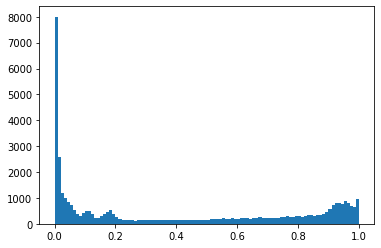

In [23]:
plt.hist(alpha[alpha<1],100)

In [24]:
beta = alpha.copy()
beta[alpha>0.5] = 1
beta[alpha<=0.5] = 0


In [25]:
J = 0*foreground
for i in range(3):
    J[:,:,i] = beta*foreground[:,:,i]+(1-beta)*background[:,:,i]

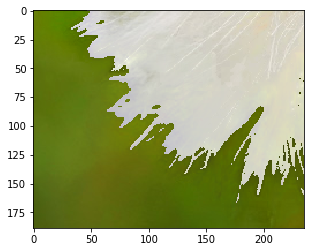

In [26]:
plt.imshow(J)